In [1]:
import asf_search as asf
from datetime import datetime
import os
from shapely import wkt
import matplotlib.pyplot as plt


In [2]:
#asf.__version__
print('cristopherfoster', 'Cri$topher19')

cristopherfoster Cri$topher19


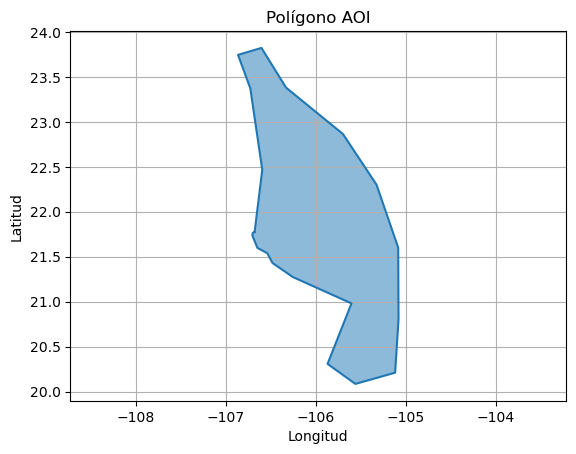

In [3]:
#
#
#MultiPolygon (((-106.68010060373566716 21.77436066337033793, -106.59471326033217053 22.46684678008129765, -106.72773775321361711 23.3725065931649425, -106.86435750265945899 23.74490799108648886, -106.6037014017430522 23.82222135658808426, -106.33046190285136845 23.3807569567040936, -105.69769674752316746 22.8649560487087733, -105.32379006482928219 22.30062841184142641, -105.0829078750168577 21.60036267216404937, -105.07931261845251925 20.80261660302085858, -105.11706281237830751 20.2099507677411232, -105.55927936979516346 20.08506621147875038, -105.86847143433048757 20.30776329118673829, -105.60242244856752336 20.9806377949139069, -106.25496151499962139 21.27407641207053857, -106.48026425969975151 21.42950196255623041, -106.53958599301175525 21.53934414912576401, -106.64864210879746054 21.59813413724725706, -106.70496779497251794 21.73540338804871297, -106.70077332898074474 21.76406583979759546, -106.68010060373566716 21.77436066337033793)))
aoi = 'POLYGON((-106.68010060373566716 21.77436066337033793, -106.59471326033217053 22.46684678008129765, -106.72773775321361711 23.3725065931649425, -106.86435750265945899 23.74490799108648886, -106.6037014017430522 23.82222135658808426, -106.33046190285136845 23.3807569567040936, -105.69769674752316746 22.8649560487087733, -105.32379006482928219 22.30062841184142641, -105.0829078750168577 21.60036267216404937, -105.07931261845251925 20.80261660302085858, -105.11706281237830751 20.2099507677411232, -105.55927936979516346 20.08506621147875038, -105.86847143433048757 20.30776329118673829, -105.60242244856752336 20.9806377949139069, -106.25496151499962139 21.27407641207053857, -106.48026425969975151 21.42950196255623041, -106.53958599301175525 21.53934414912576401, -106.64864210879746054 21.59813413724725706, -106.70496779497251794 21.73540338804871297, -106.70077332898074474 21.76406583979759546, -106.68010060373566716 21.77436066337033793))'
#-105.697 22.8649, -105.323 22.300, -105.0829 21.6003, -105.07931261845251925 20.80261660302085858, -105.11706281237830751 20.2099507677411232, -105.55927936979516346 20.08506621147875038, -105.86847143433048757 20.30776329118673829, -105.60242244856752336 20.9806377949139069, -106.25496151499962139 21.27407641207053857, -106.48026425969975151 21.42950196255623041, -106.53958599301175525 21.53934414912576401, -106.64864210879746054 21.59813413724725706, -106.70496779497251794 21.73540338804871297, -106.70077332898074474 21.76406583979759546))'


# Convertir la cadena WKT a un objeto geométrico
polygon = wkt.loads(aoi)

# Obtener las coordenadas del polígono
x, y = polygon.exterior.xy

# Graficar
plt.figure()
plt.plot(x, y)
plt.fill(x, y, alpha=0.5)
plt.title("Polígono AOI")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.axis('equal')  # Mantiene la proporción de aspecto
plt.show()

In [ ]:
Path • 136
Frame • 59 

Path • 34
Frame • 60 

Path • 34
Frame • 55 


In [4]:
# -----------------------------------------------------------------
# 2) Autenticación: necesitas tu usuario y contraseña de Earthdata
#    (si ya los guardaste en ~/.netrc puedes omitir esta parte)
# -----------------------------------------------------------------
import asf_search as asf

session = asf.ASFSession()           # crea una sesión de requests especial para ASF
session.auth_with_creds('cristopherfoster','Cri$topher19')

In [ ]:
from collections import defaultdict
import asf_search as asf
from datetime import datetime, timedelta
from pathlib import Path


year = 2023
days_window = 12               # primeros 5 días de cada mes
dest_root   = Path(r"C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023")

DATASET          = asf.DATASET.SENTINEL1
PRODUCT_TYPE     = asf.PRODUCT_TYPE.GRD_HD
FLIGHT_DIRECTION = asf.FLIGHT_DIRECTION.DESCENDING

for month in range(1, 13):
    start = datetime(year, month, 1)
    end   = start + timedelta(days=days_window - 1)

    opts = asf.ASFSearchOptions(
        dataset         = DATASET,
        processingLevel = PRODUCT_TYPE,
        flightDirection = FLIGHT_DIRECTION,
        start           = start.strftime("%Y-%m-%d"),
        end             = end.strftime("%Y-%m-%d"),
        intersectsWith  = aoi,
        # SIN maxResults → traemos todo lo que exista
    )

    # ---------- búsqueda ----------
    results = asf.search(opts=opts)
    if not results:
        print(f"⚠️  Nada entre {start:%Y-%m-%d} y {end:%Y-%m-%d}")
        continue

    # ---------- agrupar por frame ----------
    # Sentinel-1 usa 'frame'   (internamente CMR lo publica como FRAME_NUMBER)
    by_frame = defaultdict(list)
    for p in results:
        frame = p.properties.get('frame') or p.properties.get('frameNumber')
        by_frame[frame].append(p)

    # ---------- descarga el más antiguo de cada frame ----------
    for frame, prods in by_frame.items():
        prods.sort(key=lambda p: p.properties['startTime'])  # más antiguo primero
        first = prods[0]

        month_dir = dest_root / f"{year}_{month:02d}" / f"frame_{frame}"
        month_dir.mkdir(parents=True, exist_ok=True)

        first.download(path=month_dir, session=session)
        print(f"✅  {first.properties['fileName']}  → {month_dir}")


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230109T125857_20230109T125916_046707_05994A_181E.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_01\frame_525
✅  S1A_IW_GRDH_1SDV_20230109T125832_20230109T125857_046707_05994A_93E0.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_01\frame_520
✅  S1A_IW_GRDH_1SDV_20230109T125807_20230109T125832_046707_05994A_1B15.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_01\frame_515
✅  S1A_IW_GRDH_1SDV_20230104T125048_20230104T125113_046634_0596E1_4854.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_01\frame_526
✅  S1A_IW_GRDH_1SDV_20230104T125023_20230104T125048_046634_0596E1_3295.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_01\frame_521
✅  S1A_IW_GRDH_1SDV_20230102T130633_20230102T130658_046605_0595E4_46CD.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_01\frame_517


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230102T130608_20230102T130633_046605_0595E4_8B6D.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_01\frame_512
✅  S1A_IW_GRDH_1SDV_20230209T125046_20230209T125111_047159_05A87E_0351.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_02\frame_526
✅  S1A_IW_GRDH_1SDV_20230209T125021_20230209T125046_047159_05A87E_80B3.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_02\frame_521
✅  S1A_IW_GRDH_1SDV_20230207T130631_20230207T130656_047130_05A786_5B9A.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_02\frame_517
✅  S1A_IW_GRDH_1SDV_20230207T130606_20230207T130631_047130_05A786_07BB.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_02\frame_512
✅  S1A_IW_GRDH_1SDV_20230202T125856_20230202T125915_047057_05A507_C16E.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_02\frame_525
✅  S1A_IW_GRDH_1SDV_20230202T125831_2023

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230202T125806_20230202T125831_047057_05A507_1463.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_02\frame_515
✅  S1A_IW_GRDH_1SDV_20230310T125855_20230310T125915_047582_05B6CA_F996.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_03\frame_525
✅  S1A_IW_GRDH_1SDV_20230310T125830_20230310T125855_047582_05B6CA_8A32.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_03\frame_520
✅  S1A_IW_GRDH_1SDV_20230310T125805_20230310T125830_047582_05B6CA_840E.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_03\frame_515
✅  S1A_IW_GRDH_1SDV_20230305T125047_20230305T125112_047509_05B45D_0666.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_03\frame_526
✅  S1A_IW_GRDH_1SDV_20230305T125022_20230305T125047_047509_05B45D_BAAD.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_03\frame_521
✅  S1A_IW_GRDH_1SDV_20230303T130631_2023

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230303T130606_20230303T130631_047480_05B359_9256.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_03\frame_512
✅  S1A_IW_GRDH_1SDV_20230410T125047_20230410T125112_048034_05C617_1B7D.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_04\frame_526
✅  S1A_IW_GRDH_1SDV_20230410T125022_20230410T125047_048034_05C617_FD87.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_04\frame_521
✅  S1A_IW_GRDH_1SDV_20230408T130632_20230408T130657_048005_05C515_ADFD.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_04\frame_517
✅  S1A_IW_GRDH_1SDV_20230408T130607_20230408T130632_048005_05C515_BA34.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_04\frame_512
✅  S1A_IW_GRDH_1SDV_20230403T125856_20230403T125915_047932_05C298_AD8E.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_04\frame_525
✅  S1A_IW_GRDH_1SDV_20230403T125831_2023

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230403T125806_20230403T125831_047932_05C298_73D3.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_04\frame_515
✅  S1A_IW_GRDH_1SDV_20230509T125857_20230509T125917_048457_05D435_790D.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_05\frame_525
✅  S1A_IW_GRDH_1SDV_20230509T125832_20230509T125857_048457_05D435_9803.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_05\frame_520
✅  S1A_IW_GRDH_1SDV_20230509T125807_20230509T125832_048457_05D435_884A.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_05\frame_515
✅  S1A_IW_GRDH_1SDV_20230504T125048_20230504T125113_048384_05D1CF_7EF0.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_05\frame_526
✅  S1A_IW_GRDH_1SDV_20230504T125023_20230504T125048_048384_05D1CF_F8CD.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_05\frame_521
✅  S1A_IW_GRDH_1SDV_20230502T130633_2023

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230502T130608_20230502T130633_048355_05D0D7_5F1D.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_05\frame_512
✅  S1A_IW_GRDH_1SDV_20230609T125050_20230609T125115_048909_05E1B0_AF2C.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_06\frame_526
✅  S1A_IW_GRDH_1SDV_20230609T125025_20230609T125050_048909_05E1B0_2494.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_06\frame_521
✅  S1A_IW_GRDH_1SDV_20230607T130634_20230607T130659_048880_05E0CE_BB95.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_06\frame_517
✅  S1A_IW_GRDH_1SDV_20230607T130609_20230607T130634_048880_05E0CE_1909.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_06\frame_512
✅  S1A_IW_GRDH_1SDV_20230602T125859_20230602T125918_048807_05DE94_0B31.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_06\frame_525
✅  S1A_IW_GRDH_1SDV_20230602T125834_2023

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230602T125809_20230602T125834_048807_05DE94_BDB2.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_06\frame_515
✅  S1A_IW_GRDH_1SDV_20230708T125901_20230708T125920_049332_05EEA6_1CE2.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_07\frame_525
✅  S1A_IW_GRDH_1SDV_20230708T125836_20230708T125901_049332_05EEA6_B805.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_07\frame_520
✅  S1A_IW_GRDH_1SDV_20230708T125811_20230708T125836_049332_05EEA6_BA78.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_07\frame_515


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230701T130611_20230701T130647_049230_05EB70_7979.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_07\frame_512
✅  S1A_IW_GRDH_1SDV_20230808T125053_20230808T125118_049784_05FC9A_5BCF.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_08\frame_526
✅  S1A_IW_GRDH_1SDV_20230808T125028_20230808T125053_049784_05FC9A_AE80.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_08\frame_521
✅  S1A_IW_GRDH_1SDV_20230806T130638_20230806T130703_049755_05FB9F_3D62.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_08\frame_517
✅  S1A_IW_GRDH_1SDV_20230806T130613_20230806T130638_049755_05FB9F_FBF5.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_08\frame_512
✅  S1A_IW_GRDH_1SDV_20230801T125902_20230801T125921_049682_05F965_37AB.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_08\frame_525
✅  S1A_IW_GRDH_1SDV_20230801T125837_2023

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230801T125812_20230801T125837_049682_05F965_72CB.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_08\frame_515
✅  S1A_IW_GRDH_1SDV_20230911T130640_20230911T130705_050280_060D88_B4D7.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_09\frame_517
✅  S1A_IW_GRDH_1SDV_20230911T130615_20230911T130640_050280_060D88_7AC6.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_09\frame_512
✅  S1A_IW_GRDH_1SDV_20230906T125904_20230906T125923_050207_060B04_0BF7.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_09\frame_525
✅  S1A_IW_GRDH_1SDV_20230906T125839_20230906T125904_050207_060B04_2CA7.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_09\frame_520
✅  S1A_IW_GRDH_1SDV_20230906T125814_20230906T125839_050207_060B04_4451.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_09\frame_515
✅  S1A_IW_GRDH_1SDV_20230901T125055_2023

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20230901T125030_20230901T125055_050134_06089A_FB76.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_09\frame_521
✅  S1A_IW_GRDH_1SDV_20231007T125056_20231007T125121_050659_061A85_98E6.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_10\frame_526
✅  S1A_IW_GRDH_1SDV_20231007T125031_20231007T125056_050659_061A85_2663.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_10\frame_521
✅  S1A_IW_GRDH_1SDV_20231005T130640_20231005T130705_050630_061978_99B6.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_10\frame_517


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20231005T130615_20231005T130640_050630_061978_18CD.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_10\frame_512
✅  S1A_IW_GRDH_1SDV_20231110T130640_20231110T130705_051155_062B76_BA22.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_11\frame_517
✅  S1A_IW_GRDH_1SDV_20231110T130615_20231110T130640_051155_062B76_5683.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_11\frame_512
✅  S1A_IW_GRDH_1SDV_20231105T125904_20231105T125924_051082_0628EA_191B.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_11\frame_525
✅  S1A_IW_GRDH_1SDV_20231105T125839_20231105T125904_051082_0628EA_FF8B.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_11\frame_520


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20231105T125814_20231105T125839_051082_0628EA_2132.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_11\frame_515
✅  S1A_IW_GRDH_1SDV_20231211T125903_20231211T125923_051607_063B1A_C069.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_12\frame_525
✅  S1A_IW_GRDH_1SDV_20231211T125838_20231211T125903_051607_063B1A_0CF0.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_12\frame_520
✅  S1A_IW_GRDH_1SDV_20231211T125813_20231211T125838_051607_063B1A_5BBE.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_12\frame_515
✅  S1A_IW_GRDH_1SDV_20231206T125054_20231206T125119_051534_06388E_D04E.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_12\frame_526
✅  S1A_IW_GRDH_1SDV_20231206T125029_20231206T125054_051534_06388E_3E19.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\2023_12\frame_521
✅  S1A_IW_GRDH_1SDV_20231204T130639_2023

In [8]:
from collections import defaultdict
import asf_search as asf
from datetime import datetime, timedelta
from pathlib import Path


year = 2024
days_window = 12               # primeros 5 días de cada mes
dest_root   = Path(r"C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024")

DATASET          = asf.DATASET.SENTINEL1
PRODUCT_TYPE     = asf.PRODUCT_TYPE.GRD_HD
FLIGHT_DIRECTION = asf.FLIGHT_DIRECTION.DESCENDING

for month in range(1, 13):
    start = datetime(year, month, 1)
    end   = start + timedelta(days=days_window - 1)

    opts = asf.ASFSearchOptions(
        dataset         = DATASET,
        processingLevel = PRODUCT_TYPE,
        flightDirection = FLIGHT_DIRECTION,
        start           = start.strftime("%Y-%m-%d"),
        end             = end.strftime("%Y-%m-%d"),
        intersectsWith  = aoi,
        # SIN maxResults → traemos todo lo que exista
    )

    # ---------- búsqueda ----------
    results = asf.search(opts=opts)
    if not results:
        print(f"⚠️  Nada entre {start:%Y-%m-%d} y {end:%Y-%m-%d}")
        continue

    # ---------- agrupar por frame ----------
    # Sentinel-1 usa 'frame'   (internamente CMR lo publica como FRAME_NUMBER)
    by_frame = defaultdict(list)
    for p in results:
        frame = p.properties.get('frame') or p.properties.get('frameNumber')
        by_frame[frame].append(p)

    # ---------- descarga el más antiguo de cada frame ----------
    for frame, prods in by_frame.items():
        prods.sort(key=lambda p: p.properties['startTime'])  # más antiguo primero
        first = prods[0]

        month_dir = dest_root / f"{year}_{month:02d}" / f"frame_{frame}"
        month_dir.mkdir(parents=True, exist_ok=True)

        first.download(path=month_dir, session=session)
        print(f"✅  {first.properties['fileName']}  → {month_dir}")


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240111T125052_20240111T125117_052059_064AA7_CC4E.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_01\frame_526
✅  S1A_IW_GRDH_1SDV_20240111T125027_20240111T125052_052059_064AA7_A860.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_01\frame_521
✅  S1A_IW_GRDH_1SDV_20240109T130637_20240109T130702_052030_0649AC_46BA.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_01\frame_517
✅  S1A_IW_GRDH_1SDV_20240109T130612_20240109T130637_052030_0649AC_3F5C.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_01\frame_512
✅  S1A_IW_GRDH_1SDV_20240104T125902_20240104T125921_051957_064722_50A2.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_01\frame_525
✅  S1A_IW_GRDH_1SDV_20240104T125837_20240104T125902_051957_064722_7A89.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_01\frame_520


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240104T125812_20240104T125837_051957_064722_6932.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_01\frame_515
✅  S1A_IW_GRDH_1SDV_20240209T125900_20240209T125920_052482_0658EF_F6A0.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_02\frame_525
✅  S1A_IW_GRDH_1SDV_20240209T125835_20240209T125900_052482_0658EF_A540.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_02\frame_520
✅  S1A_IW_GRDH_1SDV_20240209T125810_20240209T125835_052482_0658EF_B787.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_02\frame_515
✅  S1A_IW_GRDH_1SDV_20240204T125052_20240204T125117_052409_065681_04D7.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_02\frame_526
✅  S1A_IW_GRDH_1SDV_20240204T125027_20240204T125052_052409_065681_54F9.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_02\frame_521
✅  S1A_IW_GRDH_1SDV_20240202T130636_2024

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240202T130611_20240202T130636_052380_065586_C3D0.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_02\frame_512
✅  S1A_IW_GRDH_1SDV_20240311T125052_20240311T125117_052934_06684F_3A08.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_03\frame_526
✅  S1A_IW_GRDH_1SDV_20240311T125027_20240311T125052_052934_06684F_D5EF.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_03\frame_521
✅  S1A_IW_GRDH_1SDV_20240309T130636_20240309T130701_052905_06674B_44AB.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_03\frame_517
✅  S1A_IW_GRDH_1SDV_20240309T130611_20240309T130636_052905_06674B_44D1.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_03\frame_512
✅  S1A_IW_GRDH_1SDV_20240304T125901_20240304T125920_052832_0664CE_35D8.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_03\frame_525
✅  S1A_IW_GRDH_1SDV_20240304T125836_2024

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240304T125811_20240304T125836_052832_0664CE_94DC.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_03\frame_515
✅  S1A_IW_GRDH_1SDV_20240404T125053_20240404T125118_053284_06757D_B98D.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_04\frame_526
✅  S1A_IW_GRDH_1SDV_20240404T125028_20240404T125053_053284_06757D_592D.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_04\frame_521
✅  S1A_IW_GRDH_1SDV_20240402T130637_20240402T130702_053255_06745A_3F98.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_04\frame_517


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240402T130612_20240402T130637_053255_06745A_CA31.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_04\frame_512
✅  S1A_IW_GRDH_1SDV_20240508T130638_20240508T130703_053780_068906_BFE7.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_05\frame_517
✅  S1A_IW_GRDH_1SDV_20240508T130613_20240508T130638_053780_068906_A858.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_05\frame_512
✅  S1A_IW_GRDH_1SDV_20240503T125902_20240503T125921_053707_068630_1CC8.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_05\frame_525
✅  S1A_IW_GRDH_1SDV_20240503T125837_20240503T125902_053707_068630_D0EB.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_05\frame_520


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240503T125812_20240503T125837_053707_068630_AA70.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_05\frame_515
✅  S1A_IW_GRDH_1SDV_20240608T125901_20240608T125921_054232_0698A3_9216.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_06\frame_525
✅  S1A_IW_GRDH_1SDV_20240608T125836_20240608T125901_054232_0698A3_AA94.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_06\frame_520
✅  S1A_IW_GRDH_1SDV_20240608T125811_20240608T125836_054232_0698A3_9AB5.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_06\frame_515
✅  S1A_IW_GRDH_1SDV_20240601T130637_20240601T130702_054130_069518_3E02.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_06\frame_517


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240601T130612_20240601T130637_054130_069518_DE32.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_06\frame_512
✅  S1A_IW_GRDH_1SDV_20240707T130636_20240707T130701_054655_06A751_99CB.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_07\frame_517
✅  S1A_IW_GRDH_1SDV_20240707T130611_20240707T130636_054655_06A751_DE78.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_07\frame_512
✅  S1A_IW_GRDH_1SDV_20240702T125900_20240702T125919_054582_06A4C8_47C9.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_07\frame_525
✅  S1A_IW_GRDH_1SDV_20240702T125835_20240702T125900_054582_06A4C8_2AF4.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_07\frame_520


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240702T125810_20240702T125835_054582_06A4C8_E5B0.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_07\frame_515


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


⚠️  Nada entre 2024-08-01 y 2024-08-12
✅  S1A_IW_GRDH_1SDV_20240907T125051_20240907T125116_055559_06C7DC_4111.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_09\frame_526
✅  S1A_IW_GRDH_1SDV_20240907T125026_20240907T125051_055559_06C7DC_7ABA.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_09\frame_521
✅  S1A_IW_GRDH_1SDV_20240905T130636_20240905T130701_055530_06C6B0_6049.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_09\frame_517


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20240905T130611_20240905T130636_055530_06C6B0_E861.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_09\frame_512
✅  S1A_IW_GRDH_1SDV_20241011T130637_20241011T130702_056055_06DB6F_CF59.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_10\frame_517
✅  S1A_IW_GRDH_1SDV_20241011T130612_20241011T130637_056055_06DB6F_4FD5.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_10\frame_512
✅  S1A_IW_GRDH_1SDV_20241006T125901_20241006T125921_055982_06D88B_4629.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_10\frame_525
✅  S1A_IW_GRDH_1SDV_20241006T125836_20241006T125901_055982_06D88B_2A0A.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_10\frame_520
✅  S1A_IW_GRDH_1SDV_20241006T125811_20241006T125836_055982_06D88B_BF71.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_10\frame_515
✅  S1A_IW_GRDH_1SDV_20241001T125052_2024

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20241001T125027_20241001T125052_055909_06D5B4_2286.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_10\frame_521
✅  S1A_IW_GRDH_1SDV_20241111T125901_20241111T125920_056507_06ED5D_4C3E.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_11\frame_525
✅  S1A_IW_GRDH_1SDV_20241111T125836_20241111T125901_056507_06ED5D_CEEE.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_11\frame_520
✅  S1A_IW_GRDH_1SDV_20241111T125811_20241111T125836_056507_06ED5D_2049.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_11\frame_515
✅  S1A_IW_GRDH_1SDV_20241106T125052_20241106T125117_056434_06EA77_A94A.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_11\frame_526
✅  S1A_IW_GRDH_1SDV_20241106T125027_20241106T125052_056434_06EA77_99BF.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_11\frame_521
✅  S1A_IW_GRDH_1SDV_20241104T130637_2024

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20241104T130612_20241104T130637_056405_06E950_DB2F.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_11\frame_512
✅  S1A_IW_GRDH_1SDV_20241210T130634_20241210T130659_056930_06FE1E_FFF3.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_12\frame_517
✅  S1A_IW_GRDH_1SDV_20241210T130609_20241210T130634_056930_06FE1E_4617.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_12\frame_512
✅  S1A_IW_GRDH_1SDV_20241205T125859_20241205T125918_056857_06FB49_23BD.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_12\frame_525
✅  S1A_IW_GRDH_1SDV_20241205T125834_20241205T125859_056857_06FB49_81B0.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_12\frame_520
✅  S1A_IW_GRDH_1SDV_20241205T125809_20241205T125834_056857_06FB49_D3CA.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2024\2024_12\frame_515


In [7]:
1=2

SyntaxError: cannot assign to literal (3293032332.py, line 1)

In [ ]:
from collections import defaultdict
import asf_search as asf
from datetime import datetime, timedelta
from pathlib import Path


year = 2022
days_window = 8               # primeros 5 días de cada mes
dest_root   = Path(r"C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022")

DATASET          = asf.DATASET.SENTINEL1
PRODUCT_TYPE     = asf.PRODUCT_TYPE.GRD_HD
FLIGHT_DIRECTION = asf.FLIGHT_DIRECTION.DESCENDING

for month in range(1, 13):
    start = datetime(year, month, 1)
    end   = start + timedelta(days=days_window - 1)

    opts = asf.ASFSearchOptions(
        dataset         = DATASET,
        processingLevel = PRODUCT_TYPE,
        flightDirection = FLIGHT_DIRECTION,
        start           = start.strftime("%Y-%m-%d"),
        end             = end.strftime("%Y-%m-%d"),
        intersectsWith  = aoi,
        # SIN maxResults → traemos todo lo que exista
    )

    # ---------- búsqueda ----------
    results = asf.search(opts=opts)
    if not results:
        print(f"⚠️  Nada entre {start:%Y-%m-%d} y {end:%Y-%m-%d}")
        continue

    # ---------- agrupar por frame ----------
    # Sentinel-1 usa 'frame'   (internamente CMR lo publica como FRAME_NUMBER)
    by_frame = defaultdict(list)
    for p in results:
        frame = p.properties.get('frame') or p.properties.get('frameNumber')
        by_frame[frame].append(p)

    # ---------- descarga el más antiguo de cada frame ----------
    for frame, prods in by_frame.items():
        prods.sort(key=lambda p: p.properties['startTime'])  # más antiguo primero
        first = prods[0]

        month_dir = dest_root / f"{year}_{month:02d}" / f"frame_{frame}"
        month_dir.mkdir(parents=True, exist_ok=True)

        first.download(path=month_dir, session=session)
        print(f"✅  {first.properties['fileName']}  → {month_dir}")


["'type': 'REVERSE': 'report': Reversed polygon winding order"]
c:\Users\c4cfo\anaconda3\envs\snap\lib\site-packages\asf_search\download\download.py:66: UserWarning: File already exists, skipping download: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_01\frame_517\S1A_IW_GRDH_1SDV_20220107T130623_20220107T130648_041355_04EAAB_CF1B.zip
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')


✅  S1A_IW_GRDH_1SDV_20220107T130623_20220107T130648_041355_04EAAB_CF1B.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_01\frame_517
✅  S1A_IW_GRDH_1SDV_20220107T130558_20220107T130623_041355_04EAAB_9B48.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_01\frame_512
✅  S1A_IW_GRDH_1SDV_20220102T125847_20220102T125913_041282_04E821_3591.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_01\frame_524
✅  S1A_IW_GRDH_1SDV_20220102T125822_20220102T125847_041282_04E821_9F9D.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_01\frame_519


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20220102T125757_20220102T125822_041282_04E821_728F.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_01\frame_514
✅  S1A_IW_GRDH_1SDV_20220207T125846_20220207T125912_041807_04F9E2_6C58.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_02\frame_524
✅  S1A_IW_GRDH_1SDV_20220207T125821_20220207T125846_041807_04F9E2_3576.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_02\frame_519


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20220207T125756_20220207T125821_041807_04F9E2_9D16.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_02\frame_514
✅  S1A_IW_GRDH_1SDV_20220303T125849_20220303T125909_042157_0505EF_3DE5.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_03\frame_525
✅  S1A_IW_GRDH_1SDV_20220303T125824_20220303T125849_042157_0505EF_8B02.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_03\frame_520


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20220303T125759_20220303T125824_042157_0505EF_1FCC.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_03\frame_515
✅  S1A_IW_GRDH_1SDV_20220403T125041_20220403T125106_042609_05154C_6F94.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_04\frame_526
✅  S1A_IW_GRDH_1SDV_20220403T125016_20220403T125041_042609_05154C_AE7E.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_04\frame_521
✅  S1A_IW_GRDH_1SDV_20220401T130626_20220401T130651_042580_05144B_931B.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_04\frame_517


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20220401T130601_20220401T130626_042580_05144B_3608.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_04\frame_512
✅  S1A_IW_GRDH_1SDV_20220507T130627_20220507T130652_043105_0525CA_6F92.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_05\frame_517
✅  S1A_IW_GRDH_1SDV_20220507T130602_20220507T130627_043105_0525CA_CE61.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_05\frame_512
✅  S1A_IW_GRDH_1SDV_20220502T125851_20220502T125910_043032_05235B_6372.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_05\frame_525
✅  S1A_IW_GRDH_1SDV_20220502T125826_20220502T125851_043032_05235B_0DF4.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_05\frame_520


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20220502T125801_20220502T125826_043032_05235B_9D9C.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_05\frame_515
✅  S1A_IW_GRDH_1SDV_20220607T125854_20220607T125913_043557_053367_04DA.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_06\frame_525
✅  S1A_IW_GRDH_1SDV_20220607T125829_20220607T125854_043557_053367_8CE0.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_06\frame_520
✅  S1A_IW_GRDH_1SDV_20220607T125804_20220607T125829_043557_053367_9ACB.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_06\frame_515
✅  S1A_IW_GRDH_1SDV_20220602T125045_20220602T125110_043484_053128_09DE.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_06\frame_526


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20220602T125020_20220602T125045_043484_053128_C7C7.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_06\frame_521
✅  S1A_IW_GRDH_1SDV_20220706T130631_20220706T130656_043980_053FF5_2BC6.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_07\frame_517
✅  S1A_IW_GRDH_1SDV_20220706T130606_20220706T130631_043980_053FF5_AA7B.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_07\frame_512
✅  S1A_IW_GRDH_1SDV_20220701T125855_20220701T125915_043907_053DD5_4F44.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_07\frame_525
✅  S1A_IW_GRDH_1SDV_20220701T125830_20220701T125855_043907_053DD5_D6D9.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_07\frame_520


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20220701T125805_20220701T125830_043907_053DD5_68A3.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_07\frame_515
✅  S1A_IW_GRDH_1SDV_20220806T125858_20220806T125917_044432_054D60_713F.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_08\frame_525
✅  S1A_IW_GRDH_1SDV_20220806T125833_20220806T125858_044432_054D60_5638.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_08\frame_520
✅  S1A_IW_GRDH_1SDV_20220806T125808_20220806T125833_044432_054D60_B313.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_08\frame_515
✅  S1A_IW_GRDH_1SDV_20220801T125048_20220801T125113_044359_054B3B_4568.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_08\frame_526


["'type': 'REVERSE': 'report': Reversed polygon winding order"]


✅  S1A_IW_GRDH_1SDV_20220801T125023_20220801T125048_044359_054B3B_4B8C.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_08\frame_521
✅  S1A_IW_GRDH_1SDV_20220906T125050_20220906T125115_044884_055C72_844A.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_09\frame_526
✅  S1A_IW_GRDH_1SDV_20220906T125025_20220906T125050_044884_055C72_3B46.zip  → C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2022\2022_09\frame_521


In [ ]:
1=2

In [ ]:
# -------------------------------------------------------------
# 3) Define los parámetros de la búsqueda
# -------------------------------------------------------------
# 4) Parámetros variables
year         = 2023
days_window  = 8          # cuántos días del inicio de mes se buscan
months       = range(1, 13)

search_opts = asf.ASFSearchOptions(          # forma recomendada cuando hay sesión
    dataset       = asf.DATASET.SENTINEL1,   # constante correcta del dataset  :contentReference[oaicite:0]{index=0}
    processingLevel = asf.PRODUCT_TYPE.GRD_HD,   # producto GRD alta resolución  :contentReference[oaicite:1]{index=1}
    flightDirection = asf.FLIGHT_DIRECTION.DESCENDING,  # órbita descendente  :contentReference[oaicite:2]{index=2}
    start          = "2023-06-01",
    end            = "2023-06-12",
    intersectsWith=aoi
)

# -------------------------------------------------------------
# 4) Ejecuta la búsqueda
# -------------------------------------------------------------
results = asf.search(opts=search_opts)
print(f"🔍 Se encontraron {len(results)} productos.")

# -------------------------------------------------------------
# 5) Descarga (dir_destino = carpeta donde quieres los .zip)
#    Si no hay resultados, la lista estará vacía y no descarga nada
# -------------------------------------------------------------
dir_destino =  r'C:\Users\c4cfo\OneDrive\CENTROGEO\cfoster\1_ENSOCE\C2_Data\2023\ALASKA'


if results:
    results.download(path=dir_destino, session=session)
    print("✅ Descarga terminada")
else:
    print("⚠️ No se encontraron productos con los criterios indicados")

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


🔍 Se encontraron 7 productos.
✅ Descarga terminada


In [ ]:
1=2

In [ ]:
import asf_search as asf
from datetime import datetime
import os

# Parámetros
start_date = '2023-06-01'
end_date = '2023-06-12'
processing_level = asf.PRODUCT_TYPE.GRD_HD
flight_direction = asf.FLIGHT_DIRECTION.DESCENDING
output_folder = r'C:\Users\c4cfo\OneDrive\CENTROGEO\cfoster\1_ENSOCE\C2_Data\2023'

# Crear carpeta destino si no existe
os.makedirs(output_folder, exist_ok=True)

# AOI en WKT
aoi = (
    'POLYGON((-106.680 21.774, -106.594 22.466, -106.727 23.372, '
    '-106.864 23.744, -106.603 23.822, -106.335 23.3806, -106.680 21.774))'
)

# Búsqueda
results = asf.search(
    dataset=asf.DATASET.SENTINEL_1,
    start=start_date,
    end=end_date,
    processingLevel=processing_level,
    flightDirection=flight_direction,
    intersectsWith=aoi
)

print(f"🔍 Se encontraron {len(results)} productos.")

# Descarga (incluir usuario/contraseña si no están en variables de entorno)
asf.download.download_products(
    results,
    path=output_folder,
    username='TU_USUARIO_ASF',
    password='TU_CONTRASEÑA_ASF'
)


In [ ]:
import asf_search as asf


# Parámetros
start_date = '2023-06-01'
end_date = '2023-06-12'
platform = 'Sentinel-1'
processing_level = 'GRD_HD'
orbit_direction = 'DESCENDING'
output_folder = 'C:\\Users\\c4cfo\\OneDrive\\CENTROGEO\\cfoster\\1_ENSOCE\\C2_Data\\2023'  # Carpeta destino
aoi = 'POLYGON((-106.680 21.774, -106.594 22.466, -106.727 23.372, -106.864 23.744, -106.603 23.822, -106.335 23.3806, -106.680 21.774))'



# Realizar búsqueda
results = asf.search(
    platform=platform,
    start=datetime.strptime(start_date, '%Y-%m-%d'),
    end=datetime.strptime(end_date, '%Y-%m-%d'),
    processingLevel=processing_level,
    #beamMode=beam_mode,
    orbitDirection=orbit_direction,
    intersectsWith=aoi
)

print(f"🔍 Se encontraron {len(results)} productos.")

# Descargar con carpeta destino
#asf.download.download_products(results, path=output_folder)


TypeError: search() got an unexpected keyword argument 'orbitDirection'